In [1]:
import pickle
#import sklearn
#from sklearn import metrics
#from sklearn import linear_model
#import random
#import numpy as np
#from wac import WAC
from tqdm.notebook import tqdm
import pandas as pd
#from sklearn import neural_network
#import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from collections import defaultdict as dd
import nltk 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/crow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Initiate Datasets

In [2]:
wac2vec = pickle.load(open('ddata/clip.bertvocab.embeddings.513.pkl', 'rb'))
len(wac2vec)

30522

In [3]:
concr_scores = pickle.load(open('ddata/AC_ratings_google3m_koeper_SiW.pkl', 'rb'))
len(concr_scores)

2168990

## ConcreteAbstract Class

In [4]:
class ConcreteAbstract:
    def __init__(self, word_vectors, concr_scores, word_net):
        pass

### Build Abstraction Tree

In [52]:
min_rating = 9
wac_words = list(wac2vec.keys())
wn_words = set(i for i in wn.words())
wn_wac_words = wn_words & set(wac_words)

concr_scores_subset = concr_scores[concr_scores.RATING >= min_rating]

leaf_words = [w for w in tqdm(wn_wac_words) if w in concr_scores_subset.index]
leaf_synsets = [wn.synsets(w)[0] for w in tqdm(leaf_words)]

  0%|          | 0/14510 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
cocoa

In [55]:
list(zip(leaf_words, leaf_synsets))

[('tomato', Synset('tomato.n.01')),
 ('bandage', Synset('bandage.n.01')),
 ('cereal', Synset('cereal.n.01')),
 ('pig', Synset('hog.n.03')),
 ('beetle', Synset('beetle.n.01')),
 ('lid', Synset('eyelid.n.01')),
 ('bracelet', Synset('watchband.n.01')),
 ('bra', Synset('brassiere.n.01')),
 ('gorilla', Synset('gorilla.n.01')),
 ('pizza', Synset('pizza.n.01')),
 ('shoe', Synset('shoe.n.01')),
 ('sausage', Synset('sausage.n.01')),
 ('crocodile', Synset('crocodile.n.01')),
 ('chocolate', Synset('cocoa.n.01')),
 ('frog', Synset('frog.n.01')),
 ('cocoa', Synset('cocoa.n.01')),
 ('rug', Synset('rug.n.01')),
 ('shark', Synset('shark.n.01'))]

In [ ]:
leaf_synsets

In [173]:
def init_abstraction_tree(min_rating=8):

    wac_words = list(wac2vec.keys())
    wn_words = set(i for i in wn.words())
    wn_wac_words = wn_words & set(wac_words)
    
    concr_scores_subset = concr_scores[concr_scores.RATING >= min_rating]

    leaf_words = [w for w in tqdm(wn_wac_words) if w in concr_scores_subset.index]

    # Get Leaf SynSets...
    leaf_synsets = [wn.synsets(w)[0] for w in tqdm(leaf_words)]

    # Initiate Abstraction Tree
    embeddings = [wac2vec[w] for w in tqdm(leaf_words)]
    data = {
        "SYNSET" : leaf_synsets,
        "WORD" : leaf_words,
        "DIST2LEAF": [0]*len(leaf_synsets),
        "NUM_LEAVES": [1]*len(leaf_synsets),
        "HYPERNYM": [[]]*len(leaf_synsets),
        "HYPONYMS": [[]]*len(leaf_synsets),
        "EMBEDDING" : embeddings
        
    }
    abstraction_tree = pd.DataFrame(data)
    abstraction_tree.index = abstraction_tree.SYNSET

    # Get True Leaf SynSets
    ancestors = set()
    for s in tqdm(leaf_synsets):
        #print(set(s.closure(lambda s: s.hypernyms())))
        ancestors = ancestors.union(set(s.closure(lambda s: s.hypernyms())))

    # Remove leaves that are ansestors of other leaves
    true_leaf_synsets = set(leaf_synsets) - ancestors
    ansestor_leaves = set(leaf_synsets) - true_leaf_synsets
    abstraction_tree = abstraction_tree.drop(ansestor_leaves)
    
    return abstraction_tree

In [174]:
abstraction_tree = init_abstraction_tree(9)

  0%|          | 0/14510 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('artifact.n.01') at depth 6
  for synset in acyclic_breadth_first(self, rel, depth):
/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('matter.n.03') at depth 5
  for synset in acyclic_breadth_first(self, rel, depth):
/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('entity.n.01') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):


In [175]:
len(abstraction_tree)

18

In [176]:
# Build abstraction tree

In [177]:
unprocessed_synsets = list(abstraction_tree.SYNSET)

In [178]:
wn.synset('cocoa.n.01')

Synset('cocoa.n.01')

In [179]:
# "start" here
s = unprocessed_synsets[2]
#s = wn.synset('cocoa.n.01')

In [180]:
h = s.hypernyms()[0]

In [181]:
#abstraction_tree.loc[s, 'DIST2LEAF'] = 2

In [182]:
if h not in abstraction_tree.SYNSET:
    abstraction_tree.loc[h] = [
        h,    # SYNSET
        None, # WORD
        0,    # DIST2LEAF
        0,    # NUM_LEAVES
        [],   # HYPERNYM
        [],   # HYPONYMS
        None  # EMBEDDING
    ]

In [158]:
h in abstraction_tree.SYNSET

True

In [172]:
# Set DIST2LEAF
s_dist = abstraction_tree.loc[s, 'DIST2LEAF']
h_dist = abstraction_tree.loc[h, 'DIST2LEAF']
if s_dist >= h_dist:
    abstraction_tree.loc[h, 'DIST2LEAF'] = s_dist + 1

In [183]:
# Set NUM_LEAVES
s_num_leaves = abstraction_tree.loc[s, 'NUM_LEAVES']
h_num_leaves = abstraction_tree.loc[h, 'NUM_LEAVES']
abstraction_tree.loc[h, 'NUM_LEAVES'] = h_num_leaves + s_num_leaves

In [186]:
abstraction_tree.loc[s, 'HYPERNYM'] = [h]

In [188]:
abstraction_tree.loc[h, 'HYPONYMS'].append(s)

In [189]:
abstraction_tree

,SYNSET,WORD,DIST2LEAF,NUM_LEAVES,HYPERNYM,HYPONYMS,EMBEDDING
SYNSET,,,,,,,
Synset('tomato.n.01'),Synset('tomato.n.01'),tomato,0,1,[],[],"[-0.156617, -0.061644472, 0.08238742, 0.168585..."
Synset('bandage.n.01'),Synset('bandage.n.01'),bandage,0,1,[],[],"[-0.39212647, -0.09895855, -0.19498833, 0.1028..."
Synset('cereal.n.01'),Synset('cereal.n.01'),cereal,0,1,[Synset('grass.n.01')],[],"[-0.12203906, -0.10503117, -0.055202194, 0.165..."
Synset('hog.n.03'),Synset('hog.n.03'),pig,0,1,[],[],"[-0.019314175, -0.3430049, 0.027988998, -0.070..."
Synset('beetle.n.01'),Synset('beetle.n.01'),beetle,0,1,[],[],"[-0.05565099, -0.01425737, -0.0025513684, -0.1..."
Synset('eyelid.n.01'),Synset('eyelid.n.01'),lid,0,1,[],[],"[-0.08566167, 0.091532074, -0.25215068, 0.2703..."
Synset('watchband.n.01'),Synset('watchband.n.01'),bracelet,0,1,[],[],"[-0.16948672, -0.073408335, -0.04957973, -0.26..."
Synset('brassiere.n.01'),Synset('brassiere.n.01'),bra,0,1,[],[],"[0.0060521583, -0.007831488, -0.13950057, -0.0..."
Synset('gorilla.n.01'),Synset('gorilla.n.01'),gorilla,0,1,[],[],"[0.013077118, 0.099059194, -0.09871134, -0.131..."


In [129]:
h

Synset('solanaceous_vegetable.n.01')

In [ ]:
# Left Off:
# Add ISA_LEAF and NUM_LEAVES
# NUM_LEAVES can be used to determine if we can build a classifier for the synset

In [8]:
from nltk.tree import Tree

In [9]:
class Node(str):
    def __new__(cls, value, *args, **kwargs):
        # explicitly only pass value to the str constructor
        return super(Node, cls).__new__(cls, value)

    def __init__(self, value, data):
        # ... and don't even call the str initializer 
        self.data = data

In [10]:
a = Node('test', 123)

In [11]:
t1 = Tree(a, ['2', '3', Tree('4', ['5', '6'])])
t2 = Tree('5', ['2', '3'])

In [12]:
str([1, 2])

'[1, 2]'

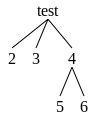

In [13]:
t1

In [14]:
#nltk.draw.tree.draw_trees([t1, t2])

In [15]:
list(t1)

['2', '3', Tree('4', ['5', '6'])]

In [16]:
help(t1)

Help on Tree in module nltk.tree.tree object:

class Tree(builtins.list)
 |  Tree(node, children=None)
 |  
 |  A Tree represents a hierarchical grouping of leaves and subtrees.
 |  For example, each constituent in a syntax tree is represented by a single Tree.
 |  
 |  A tree's children are encoded as a list of leaves and subtrees,
 |  where a leaf is a basic (non-tree) value; and a subtree is a
 |  nested Tree.
 |  
 |      >>> from nltk.tree import Tree
 |      >>> print(Tree(1, [2, Tree(3, [4]), 5]))
 |      (1 2 (3 4) 5)
 |      >>> vp = Tree('VP', [Tree('V', ['saw']),
 |      ...                  Tree('NP', ['him'])])
 |      >>> s = Tree('S', [Tree('NP', ['I']), vp])
 |      >>> print(s)
 |      (S (NP I) (VP (V saw) (NP him)))
 |      >>> print(s[1])
 |      (VP (V saw) (NP him))
 |      >>> print(s[1,1])
 |      (NP him)
 |      >>> t = Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
 |      >>> s == t
 |      True
 |      >>> t[1][1].set_label('X')
 |      >>> t[1][1].lab

In [17]:
t1.pformat()

'(test 2 3 (4 5 6))'